# Imports

In [1]:
import os
import math
import csv
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

## Data Loading & Processing

In [2]:
"""
This function removes from the TCGA dataset all rows that have TARGET-RT or TARGET-WT as a label
(which are the starting rows) and creates a list of labels from all other rows, using column 2
"""
def extract_label(file_name, verbose=False):
    data = {}
    label = []
    with open(file_name, "r") as fin:
        reader = csv.reader(fin, delimiter=',')
        first = True
        for row in reader:
            lbl = row[2]
            if first or "TARGET" in lbl:
                first = False
                continue
            lbl = lbl.replace("TCGA-","")

            label.append(lbl)
            if lbl in data.keys():
                data[lbl] += 1
            else:
                data[lbl] = 1
    if verbose:
        print(f"Number of classes in the dataset = {len(data)}")
        pprint.pprint(data, indent=4)

    return label

def create_dictionary(labels):
    dictionary = {}
    class_names = np.unique(labels)
    for i, name in enumerate(class_names):
        dictionary[name] = i
    return dictionary

def label_processing(labels):
    new_miRna_label = []
    dictionary = create_dictionary(labels)
    for label in labels:
        new_miRna_label.append(dictionary[label])
    return new_miRna_label

In [3]:

mir_dataset = "https://drive.google.com/drive/folders/1oWWeord8YYvtxIo2Pq2peyx7xOI-1Tmb?usp=sharing"
if "MLinApp_course_data" not in os.listdir("./"):
  ! gdown $mir_dataset -O ./MLinApp_course_data --folder
miR_label = extract_label("./MLinApp_course_data/tcga_mir_label.csv")
miR_data = np.genfromtxt("./MLinApp_course_data/tcga_mir_rpm.csv", delimiter=',')[1:,0:-1]


Retrieving folder list
Processing file 1p2I1VgW-0NDt9AHe0pZ6iwHB5RE5FXrv tcga_mir_label.csv
Processing file 1sqgFnNFD_IhtoQMHC_mqlupHPNqJA299 tcga_mir_rpm.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1p2I1VgW-0NDt9AHe0pZ6iwHB5RE5FXrv
To: /content/MLinApp_course_data/tcga_mir_label.csv
100% 3.99M/3.99M [00:00<00:00, 216MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sqgFnNFD_IhtoQMHC_mqlupHPNqJA299
To: /content/MLinApp_course_data/tcga_mir_rpm.csv
100% 99.8M/99.8M [00:00<00:00, 105MB/s]
Download completed


In [4]:
print(np.max(miR_data))
print(np.min(miR_data))
print(np.mean(miR_data))
print(np.var(miR_data))

937080.808473
0.0
531.6321105793392
75288464.07834613


In [5]:
number_to_delete = abs(len(miR_label) - miR_data.shape[0]) # 11082 - 11661
miR_data = miR_data[number_to_delete:,:] # as the TARGET-RT/WT rows start from zero onward
# Convert labels in number
num_miR_label = label_processing(miR_label)
# len(num_miR_label) = 33
n_classes = np.unique(miR_label).size

In [6]:
# Z-score normalization
miR_data = scipy.stats.zscore(miR_data, axis=1)

assert np.isnan(miR_data).sum() == 0

In [7]:
# log2 normalization <Optional>

miR_data = miR_data + abs(np.min(miR_data)) + 0.001
miR_data = np.log2(miR_data)

In [ ]:
# 0-255 Normalization to treat the samples as images
miR_data_min = miR_data.min()
miR_data_max = miR_data.max()

miR_data_norm = (miR_data - miR_data_min) / miR_data_max - miR_data_min

miR_data_scaled = (miR_data_norm * 255).astype(np.uint8)
miR_data = miR_data_norm

In [ ]:
# Min-max scaling
scaler = MinMaxScaler()

miR_data = scaler.fit_transform(miR_data)

Histogram of the labels

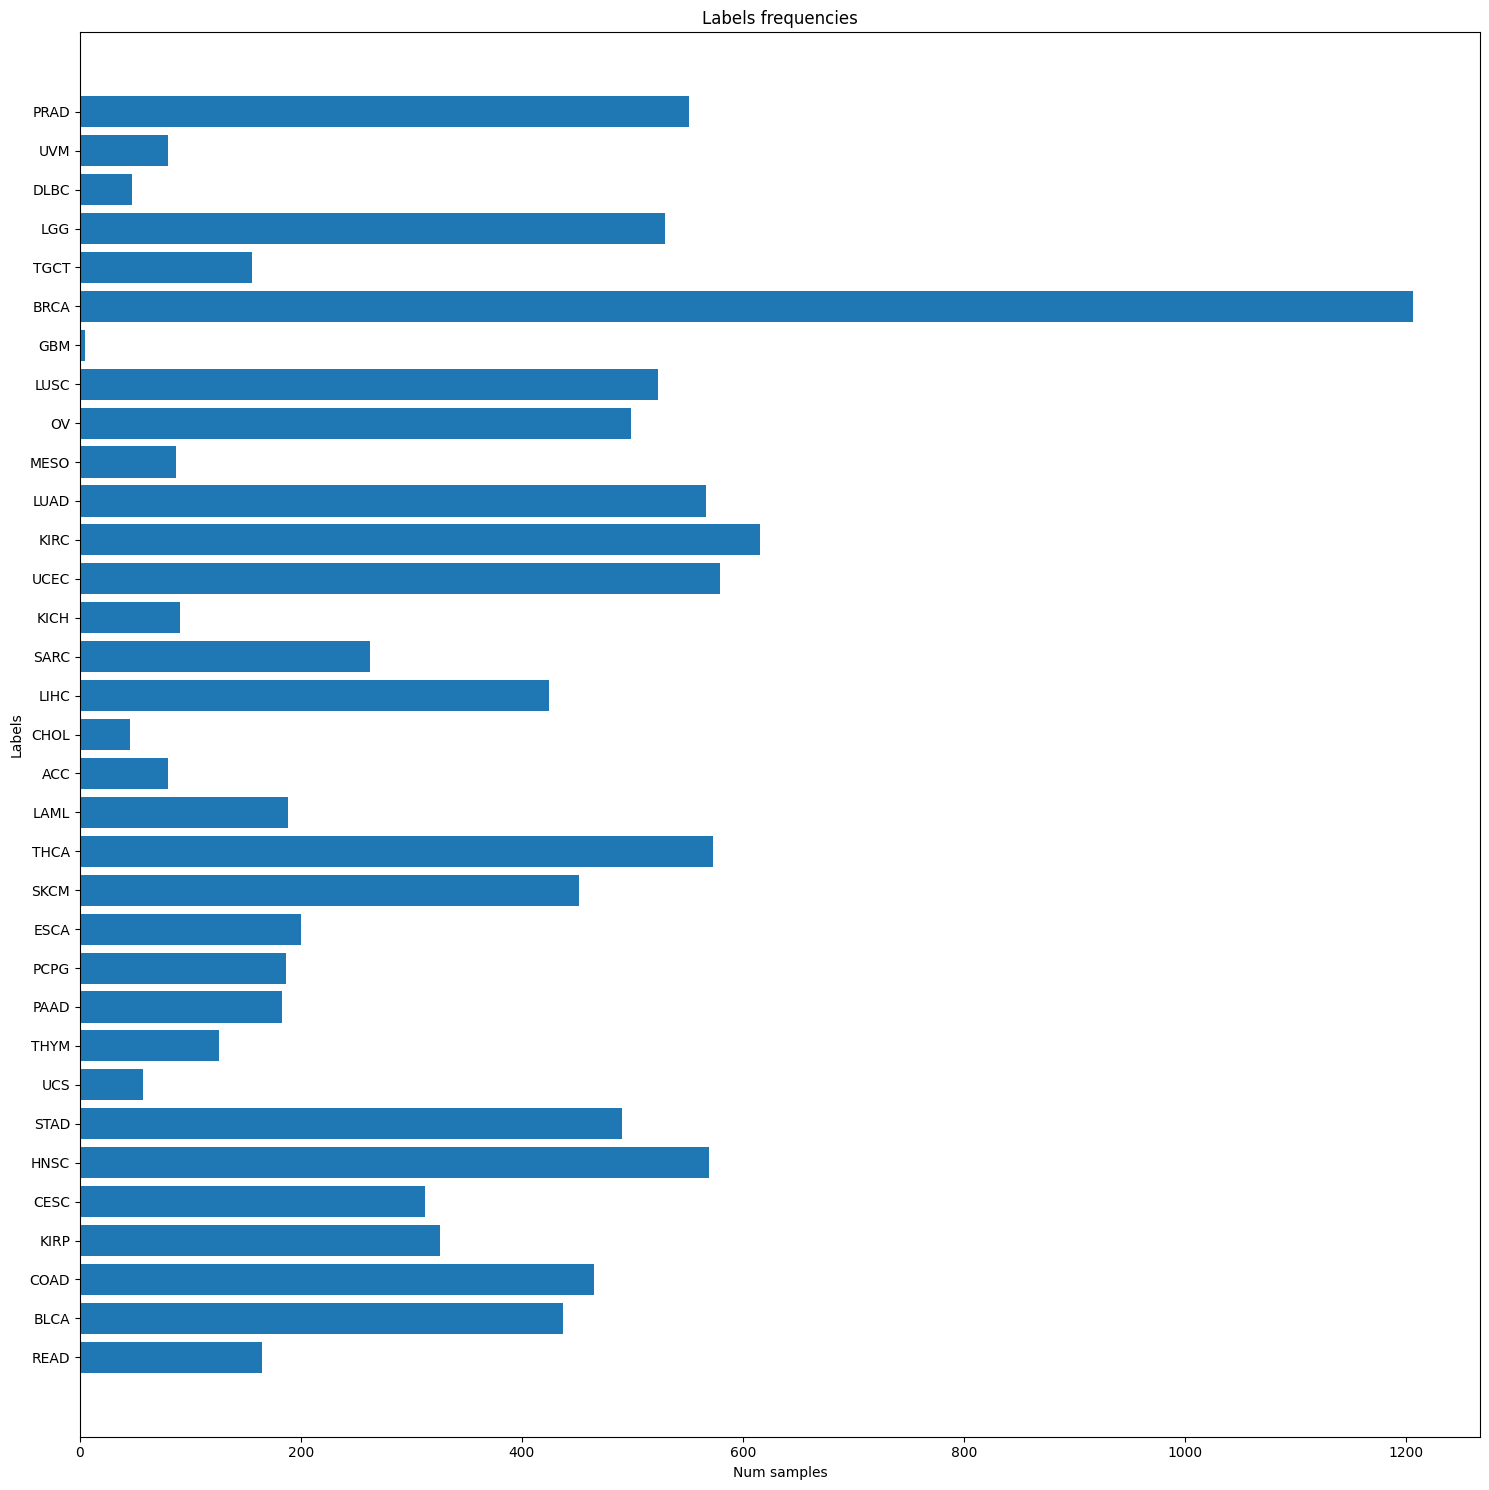

In [8]:
def plot_label_freqs(labels, title=None):
    label_freqs = {}
    for label in labels:
        if label not in label_freqs:
            label_freqs[label] = 1
        else:
            label_freqs[label] += 1

    names = list(label_freqs.keys())
    freqs = list(label_freqs.values())

    plt.figure(figsize=(15, 15)) # width:20, height:3
    plt.barh(names, freqs)
    plt.ylabel('Labels')
    plt.xlabel('Num samples')
    if title:
        plt.title(title)
    else:
        plt.title('Labels frequencies')
    plt.tight_layout()
    plt.show()

plot_label_freqs(miR_label)

Select only the top 10 classes

{'READ': 165, 'BLCA': 437, 'COAD': 465, 'KIRP': 326, 'CESC': 312, 'HNSC': 569, 'STAD': 491, 'UCS': 57, 'THYM': 126, 'PAAD': 183, 'PCPG': 187, 'ESCA': 200, 'SKCM': 452, 'THCA': 573, 'LAML': 188, 'ACC': 80, 'CHOL': 45, 'LIHC': 425, 'SARC': 263, 'KICH': 91, 'UCEC': 579, 'KIRC': 616, 'LUAD': 567, 'MESO': 87, 'OV': 499, 'LUSC': 523, 'GBM': 5, 'BRCA': 1207, 'TGCT': 156, 'LGG': 530, 'DLBC': 47, 'UVM': 80, 'PRAD': 551}
[(0, 'BRCA'), (1, 'KIRC'), (2, 'UCEC'), (3, 'THCA'), (4, 'HNSC'), (5, 'LUAD'), (6, 'PRAD'), (7, 'LGG'), (8, 'LUSC'), (9, 'OV')]


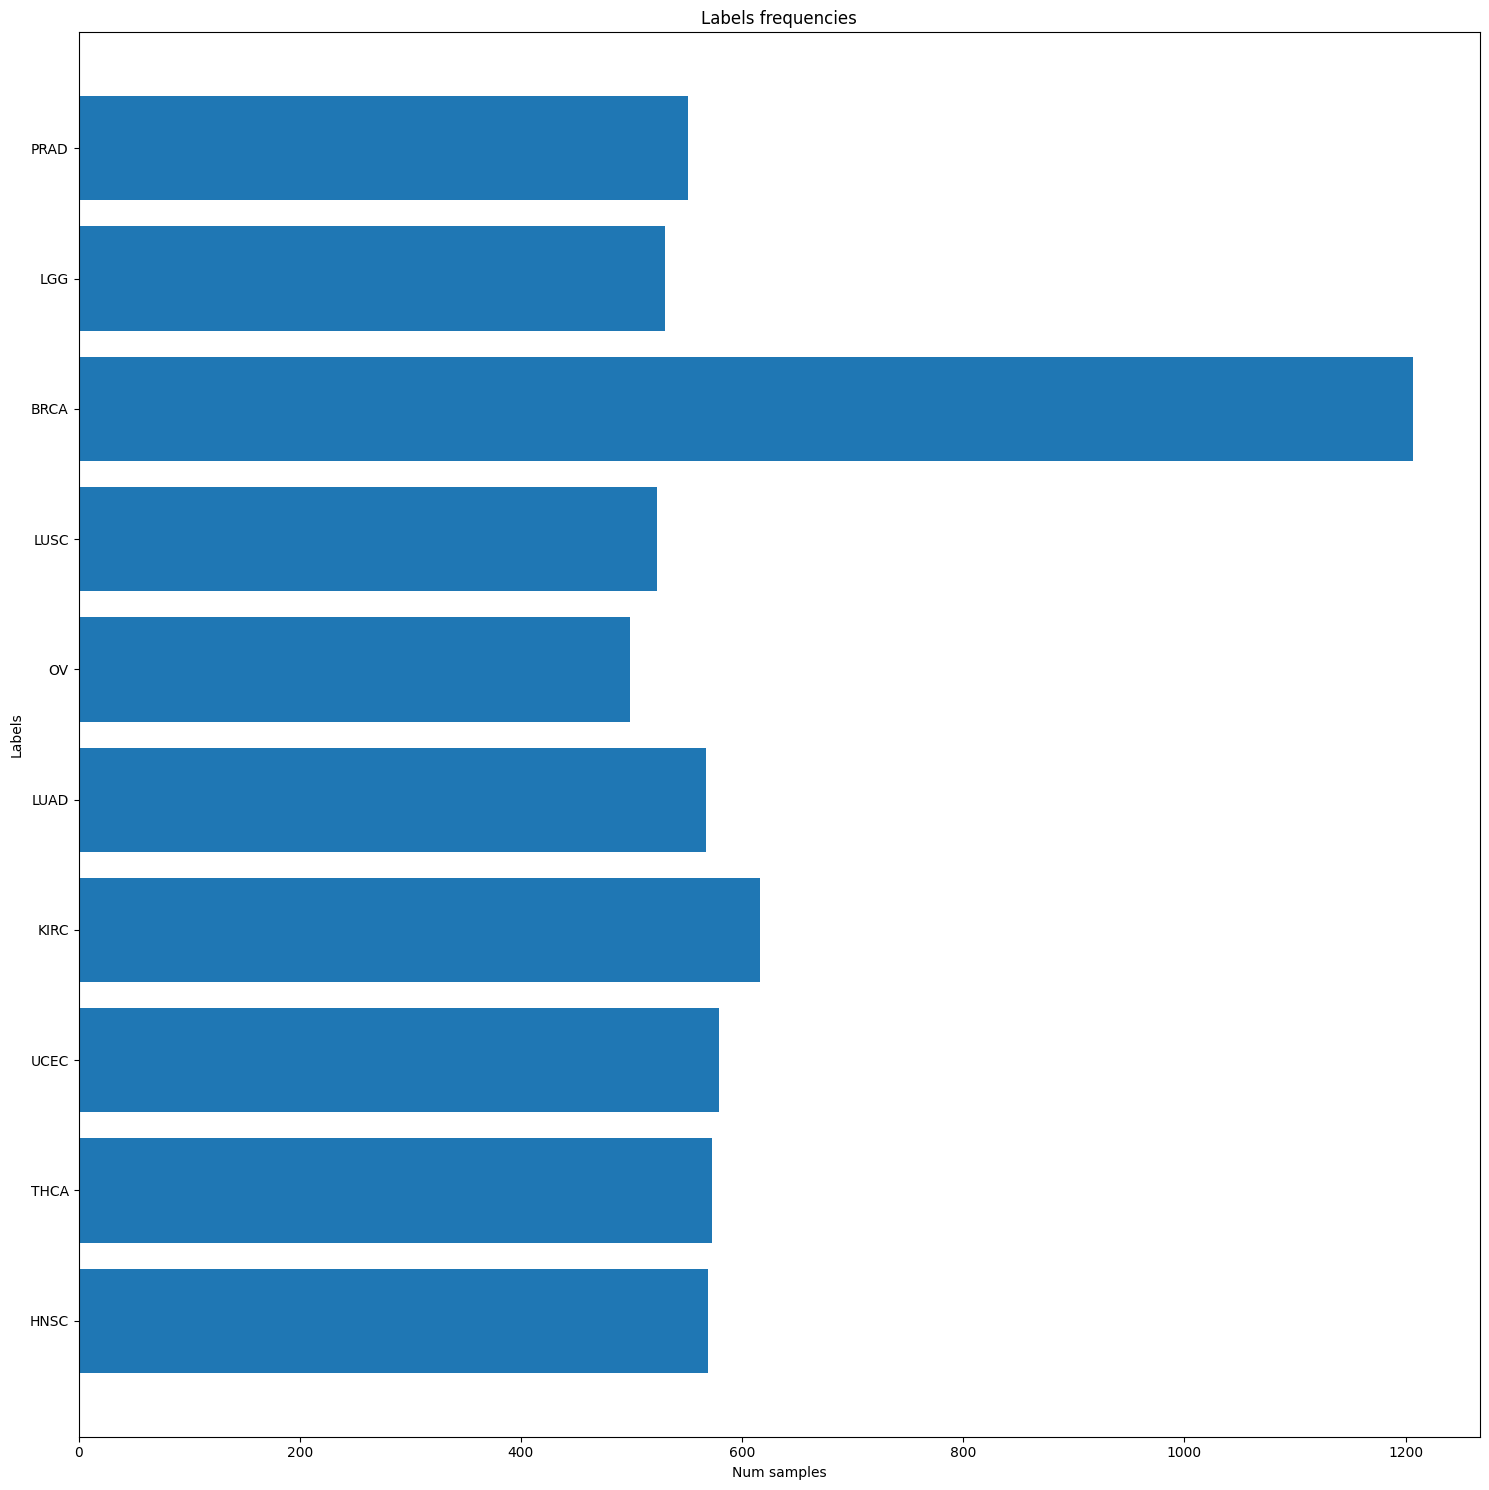

In [9]:
N = 10

miR_label_freqs = {}
for i in range(len(miR_label)):
    if miR_label[i] in miR_label_freqs:
        miR_label_freqs[miR_label[i]] += 1
    else:
        miR_label_freqs[miR_label[i]] = 1
print(miR_label_freqs)
miR_label_freqs = sorted(miR_label_freqs.items(), key=lambda item: item[1], reverse=True)[:N]
top_labels = []
for i in range(N):
    top_labels.append(miR_label_freqs[i][0])
print(list(enumerate(top_labels)))
# filter dataset
miR_data_top = []
miR_label_top = []
num_miR_label_top = []
for i in range(miR_data.shape[0]):
    label = miR_label[i]
    if label in top_labels:
        miR_data_top.append(miR_data[i])
        miR_label_top.append(miR_label[i])
        num_miR_label_top.append(top_labels.index(label))
miR_data = np.vstack(miR_data_top)
miR_label = miR_label_top
num_miR_label = num_miR_label_top
n_classes = N

plot_label_freqs(miR_label)
